## Grupo 23

**Nombre:** Raúl Miguel Carrero Martín 
**Nia**: 100451286 
**Grupo de clase**: 81

**Nombre:** Gonzalo Vela Sacristán
**Nia**: 100472334
**Grupo de clase**: 84

In [82]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install pickle
%pip install time
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\gvela\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\gvela\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\gvela\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: seaborn in c:\users\gvela\appdata\local\programs\python\python310\lib\site-packages (0.13.2)



You should consider upgrading via the 'c:\Users\gvela\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
You should consider upgrading via the 'c:\Users\gvela\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time
You should consider upgrading via the 'c:\Users\gvela\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\gvela\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# 1.- Importación de los datos y librerias

In [83]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') 


# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder


## 1.2.- Importar los datos

In [84]:
data = pd.read_csv("data/Stars2.csv")
display(data)

# Copiamos los datos y los estandarizamos
# ==============================================================================
X = data[['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class']].copy()

print("Cantidad de filas y columnas: ", X.shape)
print("Nombre de las columnas: ", X.columns)
# Mostramos las columnas con valores nulos
print("Columnas con valores nulos: ")
X.isnull().sum()
# Mostramos las columnas con NaN
print("Columnas con NaN: ")
X.isna().sum()
print('----------------')
X.describe()





,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Blue,O
237,8829,537493.000000,1423.0000,-10.73,White,A
238,9235,404940.000000,1112.0000,-11.23,White,A


Cantidad de filas y columnas:  (240, 6)
Nombre de las columnas:  Index(['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class'], dtype='object')
Columnas con valores nulos: 
Columnas con NaN: 
----------------


,Temperature,L,R,A_M
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


In [85]:
print(data.Color.unique())


# Establecemos una unificación de colores:
mapping = { 
    'Red': ['Red'],
    'Orange-Red': ['Orange-Red'],
    'Orange': ['Orange'],
    'Yellow-Orange': ['Pale yellow orange'],
    'Yellow': ['yellowish', 'Yellowish'],
    'White-Yellow': ['Yellowish White', 'yellow-white', 'White-Yellow'],
    'White': ['White', 'Whitish', 'white'],
    'Blue-White': ['Blue White', 'Blue white', 'Blue-white', 'Blue-White'],
    'Blue': ['Blue'],
}


# Mapeamos los datos
for target_color, source_colors in mapping.items():
  data.loc[data.Color.isin(source_colors), 'Color'] = target_color
data


# Comprobamos que los valores están unificados.
data.Color.unique()

# Obtenemos los colores ordenados (directamente del mapping!)
colors = list(mapping.keys())
colors


oe = OrdinalEncoder(categories=[colors])
color_encoded = oe.fit_transform(data.Color.values.reshape(-1, 1))

np.hstack([data.Color.values.reshape(-1, 1), data_encoded])




['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']


array([['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Red', 0.0],
       ['Blue-White', 5.0],
       ['White', 4.0],
       ['White', 3.0],
       ['White', 4.0],
       ['Blue-White', 5.0],
       ['White-Yellow', 3.0],
       ['Blue-White', 4.0],
       ['White-Yellow', 3.0],
       ['White-Yellow', 3.0],
       ['Yellow-Orange', 3.0],
       ['Blue', 6.0],
       ['Blue-White', 5.0],
       ['Blue-White', 5.0],
       ['White', 5.0],
       ['White-Yellow', 3.0],
       ['White', 4.0],
       ['White-Yellow', 3.0],
       ['White-Yellow', 3.0],
       ['White-Yellow', 3.0],
       ['White-Yellow', 3.0],
       ['Red', 0.0],
       ['Re

In [86]:
print(data.Spectral_Class.unique())

# Establecemos una unificación de colores:
mapping = {   # Diccionario con formato Target : List of current values
    'M': ['M'],
    'K': ['K'],
    'G': ['G'],
    'F': ['F'],
    'A': ['A'],
    'B': ['B'],
    'O': ['O'],
}


# Obtenemos los colores ordenados (directamente del mapping!)
spectral = list(mapping.keys())
spectral


oe = OrdinalEncoder(categories=[spectral])
spectral_encoded = oe.fit_transform(data.Spectral_Class.values.reshape(-1, 1))

np.hstack([data.Spectral_Class.values.reshape(-1, 1), data_encoded])



['M' 'B' 'A' 'F' 'O' 'K' 'G']


array([['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['B', 5.0],
       ['A', 4.0],
       ['F', 3.0],
       ['A', 4.0],
       ['B', 5.0],
       ['F', 3.0],
       ['A', 4.0],
       ['F', 3.0],
       ['F', 3.0],
       ['F', 3.0],
       ['O', 6.0],
       ['B', 5.0],
       ['B', 5.0],
       ['B', 5.0],
       ['F', 3.0],
       ['A', 4.0],
       ['F', 3.0],
       ['F', 3.0],
       ['F', 3.0],
       ['F', 3.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M', 0.0],
       ['B', 5.0],
       ['M', 0.0],
       ['M', 0.0],
       ['M',

In [87]:
# cambiamos los valores de las columnas categóricas a numéricas
X['Color'] = color_encoded
X['Spectral_Class'] = spectral_encoded
display(X)


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0.0,0.0
1,3042,0.000500,0.1542,16.60,0.0,0.0
2,2600,0.000300,0.1020,18.70,0.0,0.0
3,2800,0.000200,0.1600,16.65,0.0,0.0
4,1939,0.000138,0.1030,20.06,0.0,0.0
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,8.0,6.0
236,30839,834042.000000,1194.0000,-10.63,8.0,6.0
237,8829,537493.000000,1423.0000,-10.73,6.0,4.0
238,9235,404940.000000,1112.0000,-11.23,6.0,4.0


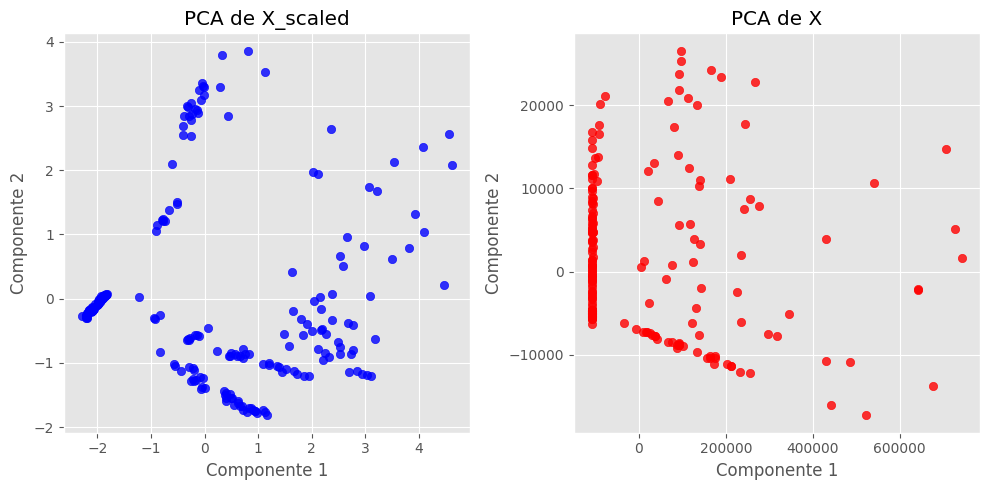

In [88]:
# PCA de los datos
# ==============================================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reducción de la dimensionalidad
# ==============================================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
Y_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca, columns=['Componente_1', 'Componente_2'])
Y_pca = pd.DataFrame(Y_pca, columns=['Componente_1', 'Componente_2'])

# Representación de los datos de fit transform de x y de x_scaled
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(X_pca['Componente_1'], X_pca['Componente_2'], alpha=.8, c='blue')
ax[0].set_xlabel('Componente 1')
ax[0].set_ylabel('Componente 2')
ax[0].set_title('PCA de X_scaled')

ax[1].scatter(Y_pca['Componente_1'], Y_pca['Componente_2'], alpha=.8, c='red')
ax[1].set_xlabel('Componente 1')
ax[1].set_ylabel('Componente 2')
ax[1].set_title('PCA de X')

plt.tight_layout()
plt.show()





,Temperature,L,R,A_M,Color_1.0,Color_2.0,Color_3.0,Color_4.0,Color_5.0,Color_6.0,Color_7.0,Color_8.0,Spectral_Class_1.0,Spectral_Class_2.0,Spectral_Class_3.0,Spectral_Class_4.0,Spectral_Class_5.0,Spectral_Class_6.0
0,3068,0.002400,0.1700,16.12,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,3042,0.000500,0.1542,16.60,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2600,0.000300,0.1020,18.70,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2800,0.000200,0.1600,16.65,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,1939,0.000138,0.1030,20.06,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,False,False,False,False,False,False,False,True,False,False,False,False,False,True
236,30839,834042.000000,1194.0000,-10.63,False,False,False,False,False,False,False,True,False,False,False,False,False,True
237,8829,537493.000000,1423.0000,-10.73,False,False,False,False,False,True,False,False,False,False,False,True,False,False
238,9235,404940.000000,1112.0000,-11.23,False,False,False,False,False,True,False,False,False,False,False,True,False,False


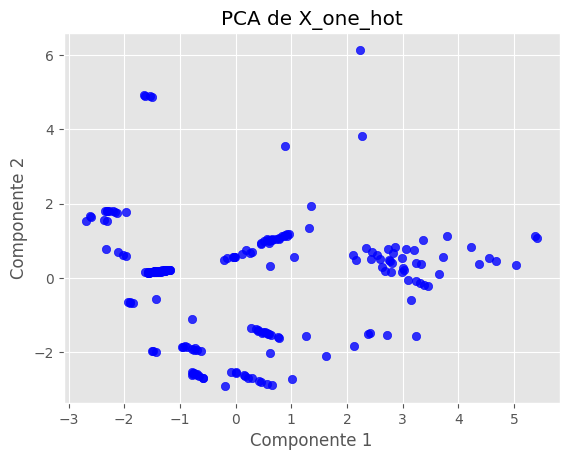

In [89]:
# hacemos lo mismo pero con one hot encoding
# ==============================================================================
X_one_hot = pd.get_dummies(X, columns=['Color', 'Spectral_Class'], drop_first=True)
X_one_hot_scaled = scaler.fit_transform(X_one_hot)
display(X_one_hot)

# Reducción de la dimensionalidad
# ==============================================================================
pca = PCA(n_components=2)
X_one_hot_pca = pca.fit_transform(X_one_hot_scaled)
X_one_hot_pca = pd.DataFrame(X_one_hot_pca, columns=['Componente_1', 'Componente_2'])

# Representación de los datos
plt.scatter(X_one_hot_pca['Componente_1'], X_one_hot_pca['Componente_2'], alpha=.8, c='blue')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA de X_one_hot')
plt.show()


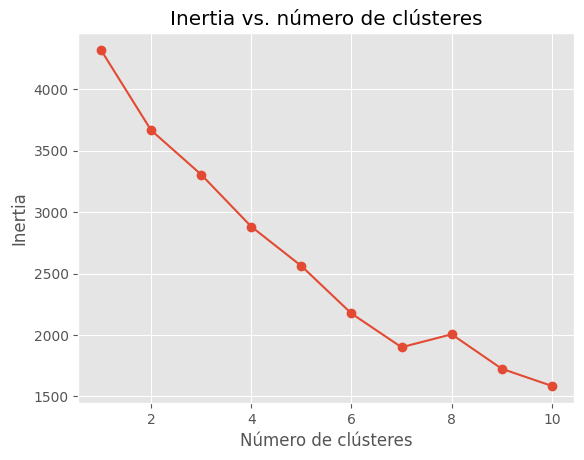

In [90]:

# Número óptimo de clústeres
# ==============================================================================
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=123).fit(X_one_hot_scaled)
    inertia.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(range(1, 11), inertia, marker='o')
ax.set_xlabel('Número de clústeres')
ax.set_ylabel('Inertia')
ax.set_title('Inertia vs. número de clústeres')
plt.show()


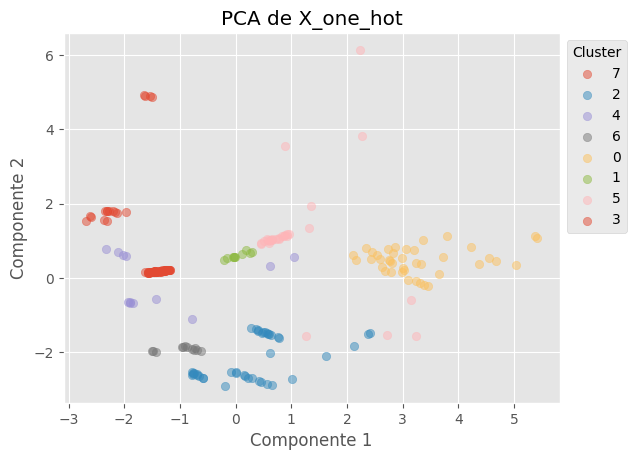

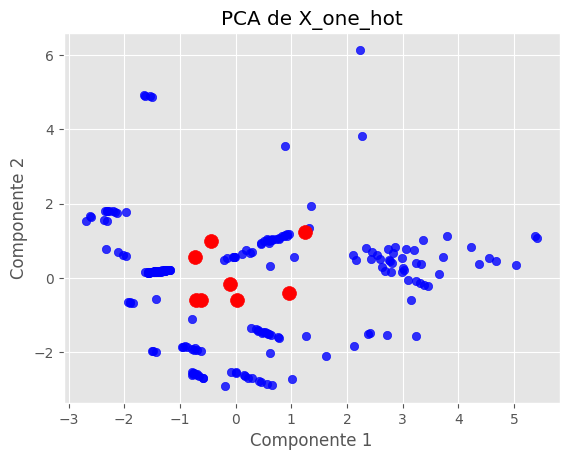

In [91]:

kmeans = KMeans(n_clusters=8, random_state=123)
kmeans.fit(X_one_hot_scaled)
X_one_hot['Cluster'] = kmeans.predict(X_one_hot_scaled)
X_one_hot['Cluster'] = X_one_hot['Cluster'].astype('category')

# Visualización de los clústeres
# ==============================================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_one_hot_scaled)
X_pca = pd.DataFrame(X_pca, columns=['Componente_1', 'Componente_2'])
X_pca['Cluster'] = kmeans.predict(X_one_hot_scaled)

fig, ax = plt.subplots()
for i in X_pca['Cluster'].unique():
    ax.scatter(
        X_pca.loc[X_pca['Cluster'] == i, 'Componente_1'],
        X_pca.loc[X_pca['Cluster'] == i, 'Componente_2'],
        label=i,
        alpha=0.5
    )

ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_title('PCA de X_one_hot')
ax.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1,1))
plt.show()


# Coordenadas de los centroides
centroids = kmeans.cluster_centers_

# Representación de los datos
plt.scatter(X_pca['Componente_1'], X_pca['Componente_2'], alpha=.8, c='blue')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA de X_one_hot')
plt.show()




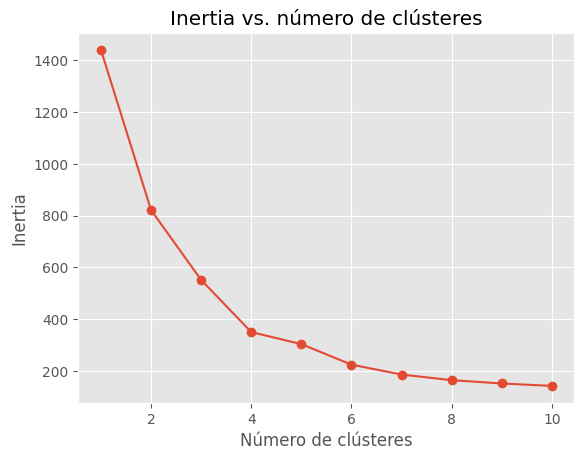

In [92]:

# Número óptimo de clústeres
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=123).fit(X_scaled)
    inertia.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(range(1, 11), inertia, marker='o')
ax.set_xlabel('Número de clústeres')
ax.set_ylabel('Inertia')
ax.set_title('Inertia vs. número de clústeres')
plt.show()

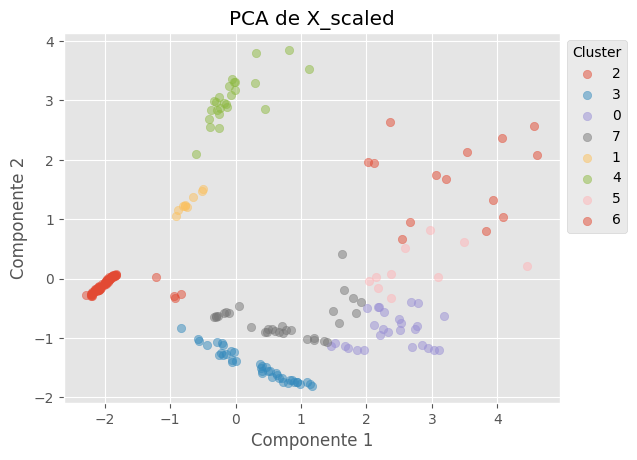

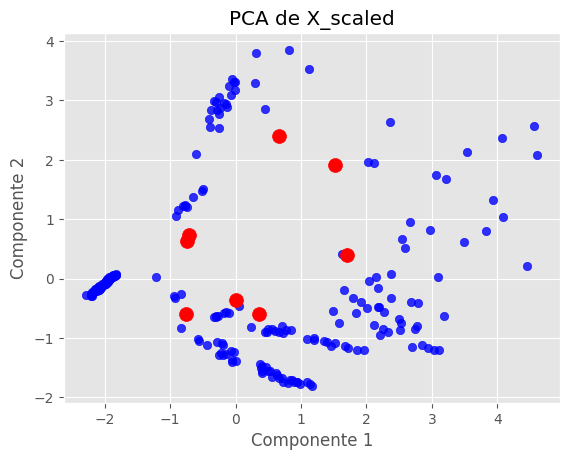

In [93]:

kmeans = KMeans(n_clusters=8, random_state=123)
kmeans.fit(X_scaled)
X['Cluster'] = kmeans.predict(X_scaled)
X['Cluster'] = X['Cluster'].astype('category')

# Visualización de los clústeres
# ==============================================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca, columns=['Componente_1', 'Componente_2'])
X_pca['Cluster'] = kmeans.predict(X_scaled)

fig, ax = plt.subplots()
for i in X_pca['Cluster'].unique():
    ax.scatter(
        X_pca.loc[X_pca['Cluster'] == i, 'Componente_1'],
        X_pca.loc[X_pca['Cluster'] == i, 'Componente_2'],
        label=i,
        alpha=0.5
    )

ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_title('PCA de X_scaled')
ax.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Coordenadas de los centroides
centroids = kmeans.cluster_centers_

# Representación de los datos
plt.scatter(X_pca['Componente_1'], X_pca['Componente_2'], alpha=.8, c='blue')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA de X_scaled')
plt.show()
